In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
from datetime import datetime
import numpy as np
import csv
import pickle
from time import sleep

import locale
locale.setlocale(locale.LC_TIME, "pl_PL")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

search_url ='https://www.otomoto.pl/osobowe/uzywane?search%5Bfilter_enum_damaged%5D=0&search%5Border%5D=created_at_first%3Adesc'

In [2]:
with open('colour_translation.csv', 'r') as data:
  for line in csv.DictReader(data):
      colour_translation = line
with open('country_mapping.csv', 'r') as data:
  for line in csv.DictReader(data):
      country_mapping = line
with open('drivetrain_translation.csv', 'r') as data:
  for line in csv.DictReader(data):
      drivetrain_translation = line
with open('fuel_translation.csv', 'r') as data:
  for line in csv.DictReader(data):
      fuel_translation = line
with open('paint_translation.csv', 'r') as data:
  for line in csv.DictReader(data):
      paint_translation = line
with open('type_translation.csv', 'r') as data:
  for line in csv.DictReader(data):
      type_translation = line
with open('makes.csv', 'r') as data:
  for line in csv.DictReader(data):
      makes = line

In [3]:
def get_searchresults(page, search_url):
    response = requests.get(search_url + '&page=' + str(page))
    search_results = BeautifulSoup(response.text, 'html.parser')
    return search_results

In [5]:
# Otomoto doesn't allow browsing offers past page 500 so we'll have to partition it
# Car maker with most offers at the time was Volskwagen with 16k which is 500 at 32 results per page so we'll use that
# Since search results will constantly shift as new offers are added it's probably best to scrape offer URLs first and scrape them later
# For this reason it's also likely it's best to scrape at night

all_listings = []
iteration = 0
limit = 500
make_list = list(makes.values())


for brand in make_list:
    brand = brand.lower().replace(' ', '-')
    # otomoto recognizees foreign diacretic chars but not polish, also there's a quirk with zastava
    brand = brand.replace('ż', 'z').replace('ł', 'l')
    brand = brand.replace('zastava', 'zastawa').replace('warszawa', 'marka-warszawa')
    search_url = 'https://www.otomoto.pl/osobowe/uzywane/{0}?search%5Bfilter_enum_damaged%5D=0'.format(brand)

    listings = []
    page = 1
    next_page = True
    prev_results = []
    
    while next_page:
        attempt = 0
        prev_fail = False
        parse_msg = '{0} page {1}'
        #print(parse_msg.format(brand, page))
        
        if page > limit: 
            break_msg = 'breaking @ {0} page {1}'
            print(break_msg.format(brand, str(page-1)))
            break

        while attempt < 3:
            print(parse_msg.format(brand, page) + ' attempt ' + str(attempt+1))            
            try:
                search_results = get_searchresults(page, search_url)
            except:
                print('Retrying after 1 min sleep')
                sleep(60)
                search_results = get_searchresults(page, search_url)
                
            results = search_results.select('main[data-testid="search-results"] > article > div > h2 > a')
            
            if results == prev_results:
                sleep(1)
                attempt += 1
                if attempt > 2: prev_fail = True
            else:
                if len(results) > 0:
                    for result in results:
                        try:
                            listing = result['href']
                            listings.append(listing)
                        except:
                            pass
                page += 1
                prev_results = results
                prev_fail = False
                break
        if prev_fail: next_page = False

    all_listings = all_listings + listings

abarth page 1 attempt 1
Retrying after 1 min sleep


In [9]:
# remove dupes
all_listings = list(dict.fromkeys(all_listings))
print(len(all_listings))

picklefile = 'offer_urls_.pkl'
with open (picklefile, 'wb') as pick:
    pickle.dump(all_listingsz, pick)

160449


In [5]:
picklefile = 'offer_urls.pkl'
with open (picklefile,'rb') as pick:
    all_listings2 = pickle.load(pick)

In [5]:
def get_listings(search_results):

    results = search_results.select('main[data-testid="search-results"] > article > div > h2 > a')
    listings = []

    for result in results:
        try:
            listing = requests.get(result['href'])
            listing_html = BeautifulSoup(listing.text, 'html.parser')
            listing_attrs = {}

            id = result['href'][-13:-5]
            listing_attrs['ID'] = id
            
            url = result['href']
            listing_attrs['url'] = url
            
            date_text = listing_html.select('span.offer-meta__value')[0].text.strip()
            date_val = datetime.strptime(date_text, '%H:%M, %d %B %Y')
            listing_attrs['Data'] = date_val

            price = listing_html.select('div.offer-price')
            listing_attrs['Cena'] = price[0]['data-price'].strip()

            currency = listing_html.select('span.offer-price__currency')
            listing_attrs['Waluta'] = currency[0].text.strip()
            
            latitude = listing_html.select('input[id="adMapData"]')
            listing_attrs['latitude'] = latitude[0]['data-map-lat'].strip()

            longitude = listing_html.select('input[id="adMapData"]')
            listing_attrs['longitude'] = longitude[0]['data-map-lon'].strip()
            
            try:
                features = listing_html.select('div.offer-features')[0].text.strip().lower()
            except:
                features = listing_html.select('div.offer-description__description')[0].text.strip().lower()
                
            if 'bluetooth' in features:
                listing_attrs['bluetooth'] = True
            else:
                listing_attrs['bluetooth'] = False
            if 'carplay' in features:
                listing_attrs['carplay'] = True
            else:
                listing_attrs['carplay'] = False
            if 'android' in features:
                listing_attrs['android'] = True
            else:
                listing_attrs['android'] = False
            if 'tempomat' in features:
                listing_attrs['cruisecontrol'] = True
            else:
                listing_attrs['cruisecontrol'] = False
            if 'kamera parkowania' in features:
                listing_attrs['camera_rear'] = True
            else:
                listing_attrs['camera_rear'] = False
            if 'czujnik deszczu' in features:
                listing_attrs['rain_sensor'] = True
            else:
                listing_attrs['rain_sensor'] = False

            all_params = listing_html.select('li.offer-params__item')

            for param in all_params:
                key = param.find('span').text
                try:
                    value = param.find('a')['title']
                except: 
                    value = param.find('div').text.strip()
                listing_attrs[key] = value
            listings.append(listing_attrs)
        except Exception as zonk:
            print(f'Couldn\'t parse listing: ' + result['href'])
    return listings

In [ ]:
listings = get_listings(search_results)
listings[0]

In [6]:
def get_dataframe(listings):
    offers_pl = pd.DataFrame.from_dict(listings)
    print('offerspl done')
    offers_pl.columns = offers_pl.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

    offers = pd.DataFrame()

    offers[['id', 'url', 'added_on', 'price', 'currency', 'latitude', 'longitude']] = \
        offers_pl[['id', 'url', 'data', 'cena', 'waluta', 'latitude', 'longitude']]       
    offers[['make', 'model', 'generation', 'version', 'type', 'year', 'total_mileage']] = \
        offers_pl[['marka_pojazdu', 'model_pojazdu', 'generacja', 'wersja', 'typ_nadwozia', 'rok_produkcji', 'przebieg']]
    offers[['fuel_type', 'engine_size', 'horsepower', 'drivetrain', 'auto_transmission', 'urban_mileage']] = \
        offers_pl[['rodzaj_paliwa', 'pojemność_skokowa', 'moc', 'napęd', 'skrzynia_biegów', 'spalanie_w_mieście']]
    offers[['doors', 'seats', 'colour', 'paint']] = \
        offers_pl[['liczba_drzwi', 'liczba_miejsc', 'kolor', 'rodzaj_koloru']]
    offers[['private_offer', 'first_registration', 'first_owner', 'pl_registered', 'country']] = \
        offers_pl[['oferta_od', 'pierwsza_rejestracja', 'pierwszy_właściciel_od_nowości', 'zarejestrowany_w_polsce', 'kraj_pochodzenia']]
    offers[['used', 'accident_free', 'aso_serviced', 'has_vin', 'financing', 'leasing']] = \
        offers_pl[['stan', 'bezwypadkowy', 'serwisowany_w_aso', 'pokaż_oferty_z_numerem_vin', 'możliwość_finansowania', 'leasing']]
    offers[['bluetooth', 'carplay', 'android', 'cruisecontrol', 'camera_rear', 'rain_sensor']] = \
        offers_pl[['bluetooth', 'carplay', 'android', 'cruisecontrol', 'camera_rear', 'rain_sensor']]
        
    offers = offers.replace({'fuel_type': fuel_translation})
    offers = offers.replace({'colour': colour_translation})
    offers = offers.replace({'paint': paint_translation})
    offers = offers.replace({'drivetrain': drivetrain_translation})
    offers = offers.replace({'type': type_translation})
    offers = offers.replace({'country': country_mapping})
    
    offers[['accident_free','aso_serviced', 'has_vin', 'financing', 'leasing', 'used', 'pl_registered', 'first_owner']] =  \
        offers[['accident_free','aso_serviced', 'has_vin', 'financing', 'leasing', 'used', 'pl_registered', 'first_owner']].fillna('Nie')

    offers = offers.replace({'Nie': False, 'Tak': True})
    offers = offers.replace({'Osoby prywatnej': True, 'Firmy': False})
    offers = offers.replace({'Używane': True, 'Nowy': False})
    offers = offers.replace({'Automatyczna': True, 'Manualna': False})

    offers['model'] = offers['model'].str.replace('Seria', 'Series', regex=False)
    offers['model'] = offers['model'].str.replace('Klasa', 'Class', regex=False)

    offers = offers.astype({'latitude': 'float', 'longitude': 'float'})
    
    offers = offers.astype({'currency': 'category', 'make': 'category', 'type': 'category', 'fuel_type': 'category'})
    offers = offers.astype({'drivetrain': 'category', 'colour': 'category', 'paint': 'category', 'country': 'category'}) 

    offers = offers.astype({'year': 'Int16'})
    offers = offers.astype({'private_offer': 'bool', 'has_vin': 'bool', 'financing': 'bool', 'leasing': 'bool', 'first_owner': 'bool'})
    offers = offers.astype({'pl_registered': 'bool', 'accident_free': 'bool', 'used': 'bool', 'aso_serviced': 'bool', 'auto_transmission': 'bool'})

    offers['urban_mileage'] = offers['urban_mileage'].str.replace(' l/100km', '', regex=False).str.replace(' ', '', regex=False)
    offers['urban_mileage'] = offers['urban_mileage'].str.replace(',', '.', regex=False).astype('float')
    offers['engine_size'] = offers['engine_size'].str.replace(' cm3', '', regex=False)
    offers['engine_size'] = offers['engine_size'].str.replace(' ', '', regex=False).astype('Int16')

    offers['price'] = offers['price'].str.replace(r'\D+', '', regex=True).astype('Int32')
    offers['total_mileage'] = offers['total_mileage'].str.replace(r'\D+', '', regex=True).astype('Int32')

    offers['horsepower'] = offers['horsepower'].str.replace(r'\D+', '', regex=True).astype('Int16')
    offers['doors'] = offers['doors'].str.replace(r'\D+', '', regex=True).astype('Int16')
    offers['seats'] = offers['seats'].str.replace(r'\D+', '', regex=True).astype('Int16')

    offers['model'] = offers['model'].str.split(" ", 1).str[1]

    offers['generation'] = offers['generation'].str.split('(').str[0][:-1]

    #offers['first_registration'] =  pd.to_datetime(offers['first_registration'], format='%d/%m/%Y', errors='coerce')
    
    return offers

In [ ]:
offers = get_dataframe(listings)

In [24]:
listings = []

for page in range(1, 3):
  search_results = get_searchresults(page)
  page_listings = get_listings(search_results)
  listings = listings + page_listings
  
offers = get_dataframe(listings)

In [8]:
def get_listings(all_urls):
    i = 0
    listings = []

    for offer_url in all_urls:
        i += 1
        print(str(i) + ': ' + offer_url)
        try:
            try:
                listing = requests.get(offer_url)
                listing_html = BeautifulSoup(listing.text, 'html.parser')
            except:
                print('retrying in 60s')
                sleep(60)
                listing = requests.get(offer_url)
                listing_html = BeautifulSoup(listing.text, 'html.parser')
            listing_attrs = {}

            id = offer_url[-13:-5]
            listing_attrs['ID'] = id
            
            url = offer_url
            listing_attrs['url'] = url
            
            date_text = listing_html.select('span.offer-meta__value')[0].text.strip()
            date_val = datetime.strptime(date_text, '%H:%M, %d %B %Y')
            listing_attrs['Data'] = date_val

            price = listing_html.select('div.offer-price')
            listing_attrs['Cena'] = price[0]['data-price'].strip()

            currency = listing_html.select('span.offer-price__currency')
            listing_attrs['Waluta'] = currency[0].text.strip()
            
            latitude = listing_html.select('input[id="adMapData"]')
            listing_attrs['latitude'] = latitude[0]['data-map-lat'].strip()

            longitude = listing_html.select('input[id="adMapData"]')
            listing_attrs['longitude'] = longitude[0]['data-map-lon'].strip()
            
            try:
                features = listing_html.select('div.offer-features')[0].text.strip().lower()
            except:
                features = listing_html.select('div.offer-description__description')[0].text.strip().lower()
                
            if 'bluetooth' in features:
                listing_attrs['bluetooth'] = True
            else:
                listing_attrs['bluetooth'] = False
            if 'carplay' in features:
                listing_attrs['carplay'] = True
            else:
                listing_attrs['carplay'] = False
            if 'android' in features:
                listing_attrs['android'] = True
            else:
                listing_attrs['android'] = False
            if 'tempomat' in features:
                listing_attrs['cruisecontrol'] = True
            else:
                listing_attrs['cruisecontrol'] = False
            if 'kamera parkowania' in features:
                listing_attrs['camera_rear'] = True
            else:
                listing_attrs['camera_rear'] = False
            if 'czujnik deszczu' in features:
                listing_attrs['rain_sensor'] = True
            else:
                listing_attrs['rain_sensor'] = False

            all_params = listing_html.select('li.offer-params__item')

            for param in all_params:
                key = param.find('span').text
                try:
                    value = param.find('a')['title']
                except: 
                    value = param.find('div').text.strip()
                listing_attrs[key] = value
            listings.append(listing_attrs)
        except Exception as zonk:
            print(f'Couldn\'t parse listing: ' + offer_url)
    return listings

In [12]:
for i in range(10, 17):
    print('Iteration: ' + str(i))
    all_listings = all_listings2[(i-1)*10000:i*10000]
    all_offers = get_listings(all_listings)
    offers = get_dataframe(all_offers)
    offers_file = 'offers_dump_{0}.feather'
    offers.to_feather(offers_file.format(i))

Iteration: 10
1: https://www.otomoto.pl/oferta/mitsubishi-outlander-i-wlasciciel-salon-pl-bezwypadkowy-zadbany-7-osob-intense-ID6EZaTR.html
2: https://www.otomoto.pl/oferta/mitsubishi-lancer-mitshubishi-lancer-ix-2-0-di-d-ID6ELYtR.html
3: https://www.otomoto.pl/oferta/mitsubishi-outlander-mitsubishi-outlander-sport-ID6EC7gq.html
4: https://www.otomoto.pl/oferta/mitsubishi-asx-alcantara-xenon-navi-sliczny-kolor-kamera-led-wzor-ID6EXonJ.html
Couldn't parse listing: https://www.otomoto.pl/oferta/mitsubishi-asx-alcantara-xenon-navi-sliczny-kolor-kamera-led-wzor-ID6EXonJ.html
5: https://www.otomoto.pl/oferta/mitsubishi-space-star-1-2-space-star-cross-limitierte-edition-ID6F2SLa.html
6: https://www.otomoto.pl/oferta/mitsubishi-outlander-2-0-intense-4wd-cvt-salon-pl-7-miejsc-ID6EZ9Dm.html
7: https://www.otomoto.pl/oferta/mitsubishi-asx-bialy-asx-full-xenon-skora-nawi-kamera-dvd-panorama-dach-ID6EUqau.html
8: https://www.otomoto.pl/oferta/mitsubishi-outlander-2-0-150km-salonpl-1wlsc-aso-bezwyp

In [11]:
offers = get_dataframe(all_offers)
offers_file = 'offers_dump_{0}.feather'
offers.to_feather(offers_file.format(9))

offerspl done


In [25]:
print(offers.dtypes)

id                            object
url                           object
added_on              datetime64[ns]
price                          Int32
currency                    category
latitude                     float64
longitude                    float64
make                        category
model                         object
generation                    object
version                       object
type                        category
year                           Int16
total_mileage                  Int32
fuel_type                   category
engine_size                    Int16
horsepower                     Int16
drivetrain                  category
auto_transmission               bool
urban_mileage                float64
doors                          Int16
seats                          Int16
colour                      category
paint                       category
private_offer                   bool
first_registration    datetime64[ns]
first_owner                     bool
p

In [ ]:
offers.to_feather('offers.arrow')

In [11]:
offers = pd.read_feather('offer_dump.feather')

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

# https://www.gov.pl/web/gugik/dane-udostepniane-bez-platnie-do-pobrania-z-serwisu-wwwgeoportalgovpl

counties = gpd.read_file('counties/counties.shp')
#counties = gpd.read_file('munis/munis.shp')
counties = counties.to_crs(epsg=4326)
counties.columns = counties.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

goffers = gpd.GeoDataFrame(offers, geometry=gpd.points_from_xy(offers.longitude, offers.latitude), crs=counties.crs)

In [30]:
goffer_wcounty = gpd.tools.sjoin(goffers, counties, predicate="within", how='left')
goffer_percounty = goffer_wcounty.groupby(['jpt_nazwa_']).size().reset_index()
goffer_percounty.rename(columns={goffer_percounty.columns[1]: "count" }, inplace = True)

counties = counties.merge(goffer_percounty, how='left', on='jpt_nazwa_')

In [42]:
counties[counties['jpt_nazwa_'].isin(['powiat Olsztyn'])] 

,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_organ_,jpt_jor_id,wersja_od,wersja_do,wazny_od,wazny_do,jpt_kod__1,...,jpt_sps_ko,id_bufor_1,jpt_id,jpt_kj_i_3,shape_leng,shape_area,geometry,count_x,count_y,count
359,POW,2862,powiat Olsztyn,None,13422,2012-09-26,None,2012-09-26,None,None,...,UZG,0,829288,None,0.70656,0.012039,"POLYGON ((20.47519 53.72413, 20.47537 53.72487...",1021,1021,1021


In [47]:
for col in offers:
  print(offers[col].unique())

['ID6F0Diy' 'ID6EPgKF' 'ID6EWmP6' ... 'ID6ENr41' 'ID6EXirP' 'ID6F2lFm']
['https://www.otomoto.pl/oferta/abarth-595-abarth-595-pista-salon-pl-idealny-ID6F0Diy.html'
 'https://www.otomoto.pl/oferta/abarth-595-abarth-595-cabrio-salon-pl-bezwypadkowy-cesja-ID6EPgKF.html'
 'https://www.otomoto.pl/oferta/abarth-595-salon-pl-na-gwarancji-od-reki-ID6EWmP6.html'
 ...
 'https://www.otomoto.pl/oferta/wolga-gaz-21-wolga-stan-bardzo-dobry-ID6ENr41.html'
 'https://www.otomoto.pl/oferta/warszawa-224-ID6EXirP.html'
 'https://www.otomoto.pl/oferta/wartburg-353-aspirujacy-zlombolista-ID6F2lFm.html']
['2022-10-24T12:08:00.000000000' '2022-10-28T12:56:00.000000000'
 '2022-10-28T18:02:00.000000000' ... '2022-10-21T18:06:00.000000000'
 '2022-10-22T15:36:00.000000000' '2022-10-24T00:11:00.000000000']
<IntegerArray>
[ 76000, 110000,  95900,  59999,  31900, 133900,  71900,  91000,  95000,
  20500,
 ...
 138434, 154950,  71002,  14867,  53450,  99937, 186798, 140322, 204500,
 184746]
Length: 7602, dtype: Int32


In [45]:
counties.iloc[0]

jpt_sjr_ko                                                  POW
jpt_kod_je                                                 1815
jpt_nazwa_                        powiat ropczycko-sędziszowski
jpt_organ_                                                 None
jpt_jor_id                                                13415
wersja_od                                            2012-09-26
wersja_do                                                  None
wazny_od                                             2012-09-26
wazny_do                                                   None
jpt_kod__1                                                 None
jpt_nazwa1                                                 None
jpt_organ1                                                  NZN
jpt_wazna_                                                  NZN
id_bufora_                                              13878.0
id_bufora1                                                  0.0
id_technic                              

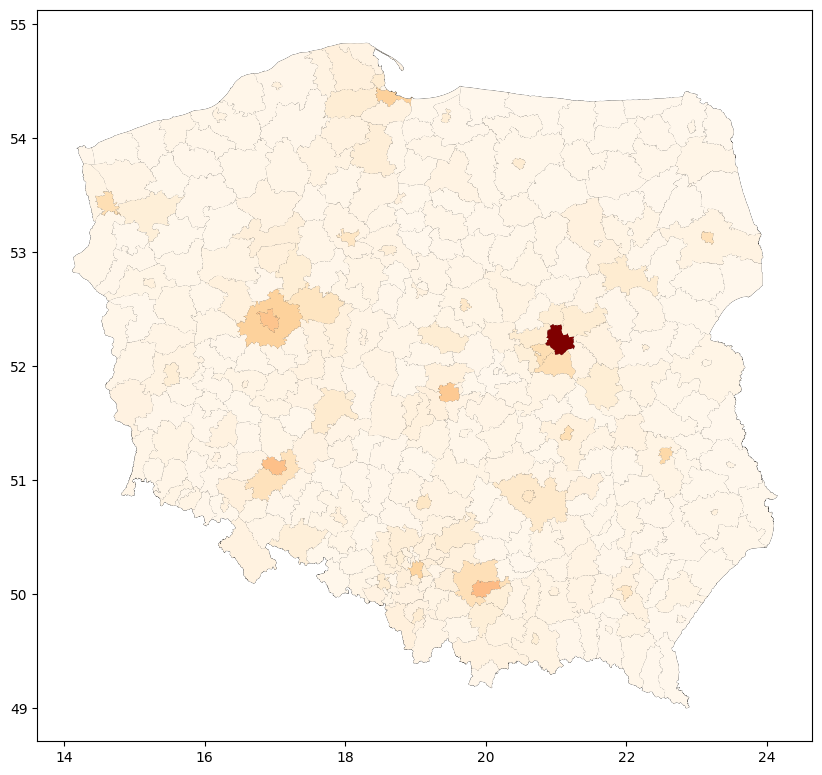

In [24]:
base = counties.plot(color='white', edgecolor='black', figsize=(10, 10), linewidth=0.3)
counties.plot(ax=base, column='count', cmap='OrRd', figsize=(10, 10))
plt.show()

In [4]:
offerdump = pd.read_feather('offers_dump_99.feather')

In [11]:
# test parsing of individual offer

parse_url = 'https://www.otomoto.pl/oferta/volkswagen-polo-zarejestrowany-klima-ID6F3PZT.html'

listing = requests.get(parse_url)
listing_html = BeautifulSoup(listing.text, 'html.parser')
listing_attrs = {}

id = parse_url[-13:-5]
listing_attrs['ID'] = id

url = parse_url
listing_attrs['url'] = url

date_text = listing_html.select('span.offer-meta__value')[0].text.strip()
date_val = datetime.strptime(date_text, '%H:%M, %d %B %Y')
listing_attrs['Data'] = date_val

price = listing_html.select('div.offer-price')
listing_attrs['Cena'] = price[0]['data-price'].strip()

currency = listing_html.select('span.offer-price__currency')
listing_attrs['Waluta'] = currency[0].text.strip()

latitude = listing_html.select('input[id="adMapData"]')
listing_attrs['latitude'] = latitude[0]['data-map-lat'].strip()

longitude = listing_html.select('input[id="adMapData"]')
listing_attrs['longitude'] = longitude[0]['data-map-lon'].strip()

try:
    features = listing_html.select('div.offer-features')[0].text.strip()
except:
    features = listing_html.select('div.offer-description__description')[0].text.strip()
    
if 'bluetooth' in features:
    listing_attrs['bluetooth'] = True
else:
    listing_attrs['bluetooth'] = False
if 'carplay' in features:
    listing_attrs['carplay'] = True
else:
    listing_attrs['carplay'] = False
if 'android' in features:
    listing_attrs['android'] = True
else:
    listing_attrs['android'] = False
if 'tempomat' in features:
    listing_attrs['cruisecontrol'] = True
else:
    listing_attrs['cruisecontrol'] = False
if 'kamera parkowania' in features:
    listing_attrs['camera_rear'] = True
else:
    listing_attrs['camera_rear'] = False
if 'czujnik deszczu' in features:
    listing_attrs['rain_sensor'] = True
else:
    listing_attrs['rain_sensor'] = False

all_params = listing_html.select('li.offer-params__item')

for param in all_params:
    key = param.find('span').text
    try:
        value = param.find('a')['title']
    except: 
        value = param.find('div').text.strip()
    listing_attrs[key] = value

In [10]:
i = int(len(all_listings2) / 128) + 1
x

1254